# Load Data

In [34]:
dataset_path = "3d-dataset-224-slices"

In [35]:
import pandas as pd
survivor = pd.read_csv("datasets/dataset-survivor.csv")

In [36]:
import glob
import os

def get_data(subjects_dir):
    return [os.path.basename(f) for f in glob.glob(f"{subjects_dir}/*")]

In [37]:
subjects = get_data(dataset_path)

In [38]:
dataset = survivor[survivor['Path'].isin(subjects)][['Path', 'Survival']]

## Categorical labels

In [39]:
import numpy as np

X, labels = np.array(dataset.iloc[:,0]), np.array(dataset.iloc[:,1])

In [40]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

def categorical(labels):
    le = LabelEncoder().fit(labels)
    return to_categorical(le.transform(labels), 2)

## Train and test

In [41]:
from sklearn.model_selection import train_test_split

(trainX, testX, trainY, testY) = train_test_split(X, labels, test_size=0.2, random_state=42) # stratify=labels

## Load slices

In [42]:
ls {dataset_path}/{subject}/*.png

3d-dataset-224-slices/TOMEO_VINCENZO/0.png
3d-dataset-224-slices/TOMEO_VINCENZO/1.png
3d-dataset-224-slices/TOMEO_VINCENZO/10.png
3d-dataset-224-slices/TOMEO_VINCENZO/100.png
3d-dataset-224-slices/TOMEO_VINCENZO/101.png
3d-dataset-224-slices/TOMEO_VINCENZO/102.png
3d-dataset-224-slices/TOMEO_VINCENZO/103.png
3d-dataset-224-slices/TOMEO_VINCENZO/104.png
3d-dataset-224-slices/TOMEO_VINCENZO/105.png
3d-dataset-224-slices/TOMEO_VINCENZO/106.png
3d-dataset-224-slices/TOMEO_VINCENZO/107.png
3d-dataset-224-slices/TOMEO_VINCENZO/108.png
3d-dataset-224-slices/TOMEO_VINCENZO/109.png
3d-dataset-224-slices/TOMEO_VINCENZO/11.png
3d-dataset-224-slices/TOMEO_VINCENZO/110.png
3d-dataset-224-slices/TOMEO_VINCENZO/111.png
3d-dataset-224-slices/TOMEO_VINCENZO/112.png
3d-dataset-224-slices/TOMEO_VINCENZO/113.png
3d-dataset-224-slices/TOMEO_VINCENZO/114.png
3d-dataset-224-slices/TOMEO_VINCENZO/115.png
3d-dataset-224-slices/TOMEO_VINCENZO/116.png
3d-dataset-224-slices/TOMEO_VINCENZO/117.png
3d-dataset-224-s

In [43]:
%%time

import imageio

train_X = []
train_Y = []

for subject, label in zip(trainX, trainY):
    print("Working with", subject)
    for file in glob.glob(f"{dataset_path}/{subject}/*.png"):
        train_X.append(imageio.imread(file))
        train_Y.append(label)

Working with FIUCCI_A
Working with SYKULA_GRAZYNA_BARBARA
Working with RICCI_ALESSANDRO
Working with RUSNAC_NINA
Working with RUSCITO_ELISABETTA
Working with INCITI_DONATA
Working with DI_LORENZO_TOMMASO
Working with CELLINI_T
Working with SOLOVIY_VOLODYMYR
Working with MARAGNO_CLARA
Working with SALTARELLI_DOMENICO
Working with DARIDA
Working with LO_BELLO_MARIO
Working with CAPEZZONE
Working with STAN_FLORENTINA
Working with MASCI_ADA
Working with BEVILACQUA_RITA
Working with GEGGI_GIULIO
Working with IONTA_LUCIANA
Working with ROMITO_ORAZIO
Working with CHERRI_M
Working with QUACQUARELLI_A
Working with PROIETTI_MARIA
Working with DI_CARLATONIO_MAURIZIO
Working with BAGNOLI_VINCENZO
Working with COLETTA_MARIA
Working with MARTINEZ
Working with RE_ATTILIO
Working with GIORDANO_STEFANIA
Working with BOEZI_MARIO
Working with TROSCIA_M
Working with BERTUZZI_LUISA
Working with PINEDA_MARIA_ASSUNTA
Working with VERONESI_ROCCO
Working with ALESSANDRINI_GLAUCO
Working with PISTOIA_CARLO
Work

In [44]:
%%time

import imageio

test_X = []
test_Y = []

for subject, label in zip(testX, testY):
    print("Working with", subject)
    for file in glob.glob(f"{dataset_path}/{subject}/*.png"):
        test_X.append(imageio.imread(file))
        test_Y.append(label)

Working with NERVEGNA_G
Working with ISONI_FRANCESCO
Working with MARIANI_BERNARDO
Working with LUPI_GIANCARLO
Working with POMPEI_F
Working with COLAFRANCESCO_ROCCO
Working with MUSAT_DORINA
Working with SANTINI_ERMANNO
Working with MOVIA_A
Working with TAVERNESE_G
Working with CALDARONI_ANNA
Working with MONACELLI_LAURA
Working with BIAVATI_S
Working with RONZO_F
Working with CARZEDDA_PAOLO
Working with COLAMARTINI_GIUSEPPINA
Working with QUATTROCIOCCHI_EVELINA
Working with PALMA
Working with ZAMPELLA_A
Working with MAIOLINI_SANTA
Working with PAGANNONE_GIANNI
Working with CACACE_PAOLO
Working with BIANCHI_GIOVANNI
Working with BERNOLA_TERESA
Working with COLAZZO_LUIGI_GIUSEPPE
Working with PASCARELLA_P
Working with ISMAIL_A
Working with FILIPPONI_QUINTINO
Working with FABIANI_ANNA
Working with ORLANDI_PAOLO
Working with DI_MASSA_SERGIO
Working with TOMEO_VINCENZO
CPU times: user 9.07 s, sys: 597 ms, total: 9.67 s
Wall time: 9.63 s


# Fine tuning InceptionV3

In [76]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [77]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

In [78]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# and a logistic layer -- let's say we have 200 classes
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [79]:
rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

In [80]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=rmsprop, loss='categorical_crossentropy', metrics=['accuracy','binary_crossentropy'])

In [81]:
'''Model fitting'''
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/scalars/inceptionv3")

In [82]:
epochs = 10  # Increase this value for better results (i.e., more training)

batch_size = 16  # Increasing this value might speed up fitting

In [83]:
# Fit
fit = model.fit(
        np.array(train_X), categorical(np.array(train_Y)), 
        epochs=epochs,
        callbacks=[tensorboard_callback, early_stopping_callback],
        validation_data=(np.array(test_X), categorical(np.array(test_Y))), 
        # shuffle=True,
        batch_size=batch_size)

Train on 21728 samples, validate on 5152 samples
Epoch 1/10
21728/21728 [==============================] - 83s 4ms/sample - loss: 0.5506 - acc: 0.7129 - binary_crossentropy: 0.5506 - val_loss: 6.1550 - val_acc: 0.6106 - val_binary_crossentropy: 4.5232
Epoch 2/10
21728/21728 [==============================] - 76s 4ms/sample - loss: 0.4273 - acc: 0.7966 - binary_crossentropy: 0.4273 - val_loss: 16.5404 - val_acc: 0.5912 - val_binary_crossentropy: 5.9853
Epoch 3/10
21728/21728 [==============================] - 76s 4ms/sample - loss: 0.3519 - acc: 0.8429 - binary_crossentropy: 0.3519 - val_loss: 16.8290 - val_acc: 0.5899 - val_binary_crossentropy: 5.8831
Epoch 4/10
21728/21728 [==============================] - 76s 4ms/sample - loss: 0.2986 - acc: 0.8704 - binary_crossentropy: 0.2986 - val_loss: 31.5428 - val_acc: 0.6017 - val_binary_crossentropy: 5.9246
Epoch 5/10
21728/21728 [==============================] - 77s 4ms/sample - loss: 0.2544 - acc: 0.8934 - binary_crossentropy: 0.2544 - va

In [84]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_5
1 conv2d_188
2 batch_normalization_188
3 activation_188
4 conv2d_189
5 batch_normalization_189
6 activation_189
7 conv2d_190
8 batch_normalization_190
9 activation_190
10 max_pooling2d_8
11 conv2d_191
12 batch_normalization_191
13 activation_191
14 conv2d_192
15 batch_normalization_192
16 activation_192
17 max_pooling2d_9
18 conv2d_196
19 batch_normalization_196
20 activation_196
21 conv2d_194
22 conv2d_197
23 batch_normalization_194
24 batch_normalization_197
25 activation_194
26 activation_197
27 average_pooling2d_18
28 conv2d_193
29 conv2d_195
30 conv2d_198
31 conv2d_199
32 batch_normalization_193
33 batch_normalization_195
34 batch_normalization_198
35 batch_normalization_199
36 activation_193
37 activation_195
38 activation_198
39 activation_199
40 mixed0
41 conv2d_203
42 batch_normalization_203
43 activation_203
44 conv2d_201
45 conv2d_204
46 batch_normalization_201
47 batch_normalization_204
48 activation_201
49 activation_204
50 average_pooling2d_19
51 conv2d_200
52 c

In [85]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

In [89]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy','binary_crossentropy'])

In [90]:
epochs = 100

In [91]:
'''Model fitting'''
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/scalars/inceptionv3")

In [92]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
fit = model.fit(
        np.array(train_X), categorical(np.array(train_Y)), 
        epochs=epochs,
        callbacks=[tensorboard_callback, early_stopping_callback],
        validation_data=(np.array(test_X), categorical(np.array(test_Y))), 
        batch_size=batch_size)

Train on 21728 samples, validate on 5152 samples
Epoch 1/100
21728/21728 [==============================] - 110s 5ms/sample - loss: 0.0606 - acc: 0.9770 - binary_crossentropy: 0.0606 - val_loss: 27.3029 - val_acc: 0.5873 - val_binary_crossentropy: 6.1511
Epoch 2/100
21728/21728 [==============================] - 102s 5ms/sample - loss: 0.0543 - acc: 0.9786 - binary_crossentropy: 0.0543 - val_loss: 22.1834 - val_acc: 0.5856 - val_binary_crossentropy: 6.0481
Epoch 3/100
21728/21728 [==============================] - 101s 5ms/sample - loss: 0.0439 - acc: 0.9825 - binary_crossentropy: 0.0439 - val_loss: 24.0061 - val_acc: 0.5883 - val_binary_crossentropy: 6.0445
Epoch 4/100
21728/21728 [==============================] - 101s 5ms/sample - loss: 0.0405 - acc: 0.9833 - binary_crossentropy: 0.0405 - val_loss: 17.1037 - val_acc: 0.5466 - val_binary_crossentropy: 5.8813
Epoch 5/100
21728/21728 [==============================] - 101s 5ms/sample - loss: 0.0366 - acc: 0.9847 - binary_crossentropy: 

21728/21728 [==============================] - 106s 5ms/sample - loss: 0.0186 - acc: 0.9901 - binary_crossentropy: 0.0186 - val_loss: 14.8917 - val_acc: 0.4511 - val_binary_crossentropy: 6.8372
Epoch 41/100
21728/21728 [==============================] - 105s 5ms/sample - loss: 0.0189 - acc: 0.9905 - binary_crossentropy: 0.0189 - val_loss: 20.8593 - val_acc: 0.4350 - val_binary_crossentropy: 7.4245
Epoch 42/100
21728/21728 [==============================] - 105s 5ms/sample - loss: 0.0180 - acc: 0.9896 - binary_crossentropy: 0.0180 - val_loss: 15.2326 - val_acc: 0.4499 - val_binary_crossentropy: 7.0359
Epoch 43/100
21728/21728 [==============================] - 106s 5ms/sample - loss: 0.0193 - acc: 0.9899 - binary_crossentropy: 0.0193 - val_loss: 18.6834 - val_acc: 0.4297 - val_binary_crossentropy: 7.4878
Epoch 44/100
 1136/21728 [>.............................] - ETA: 1:22 - loss: 0.0189 - acc: 0.9903 - binary_crossentropy: 0.0189

KeyboardInterrupt: 

# Visualize

Show some pictures from train dataset

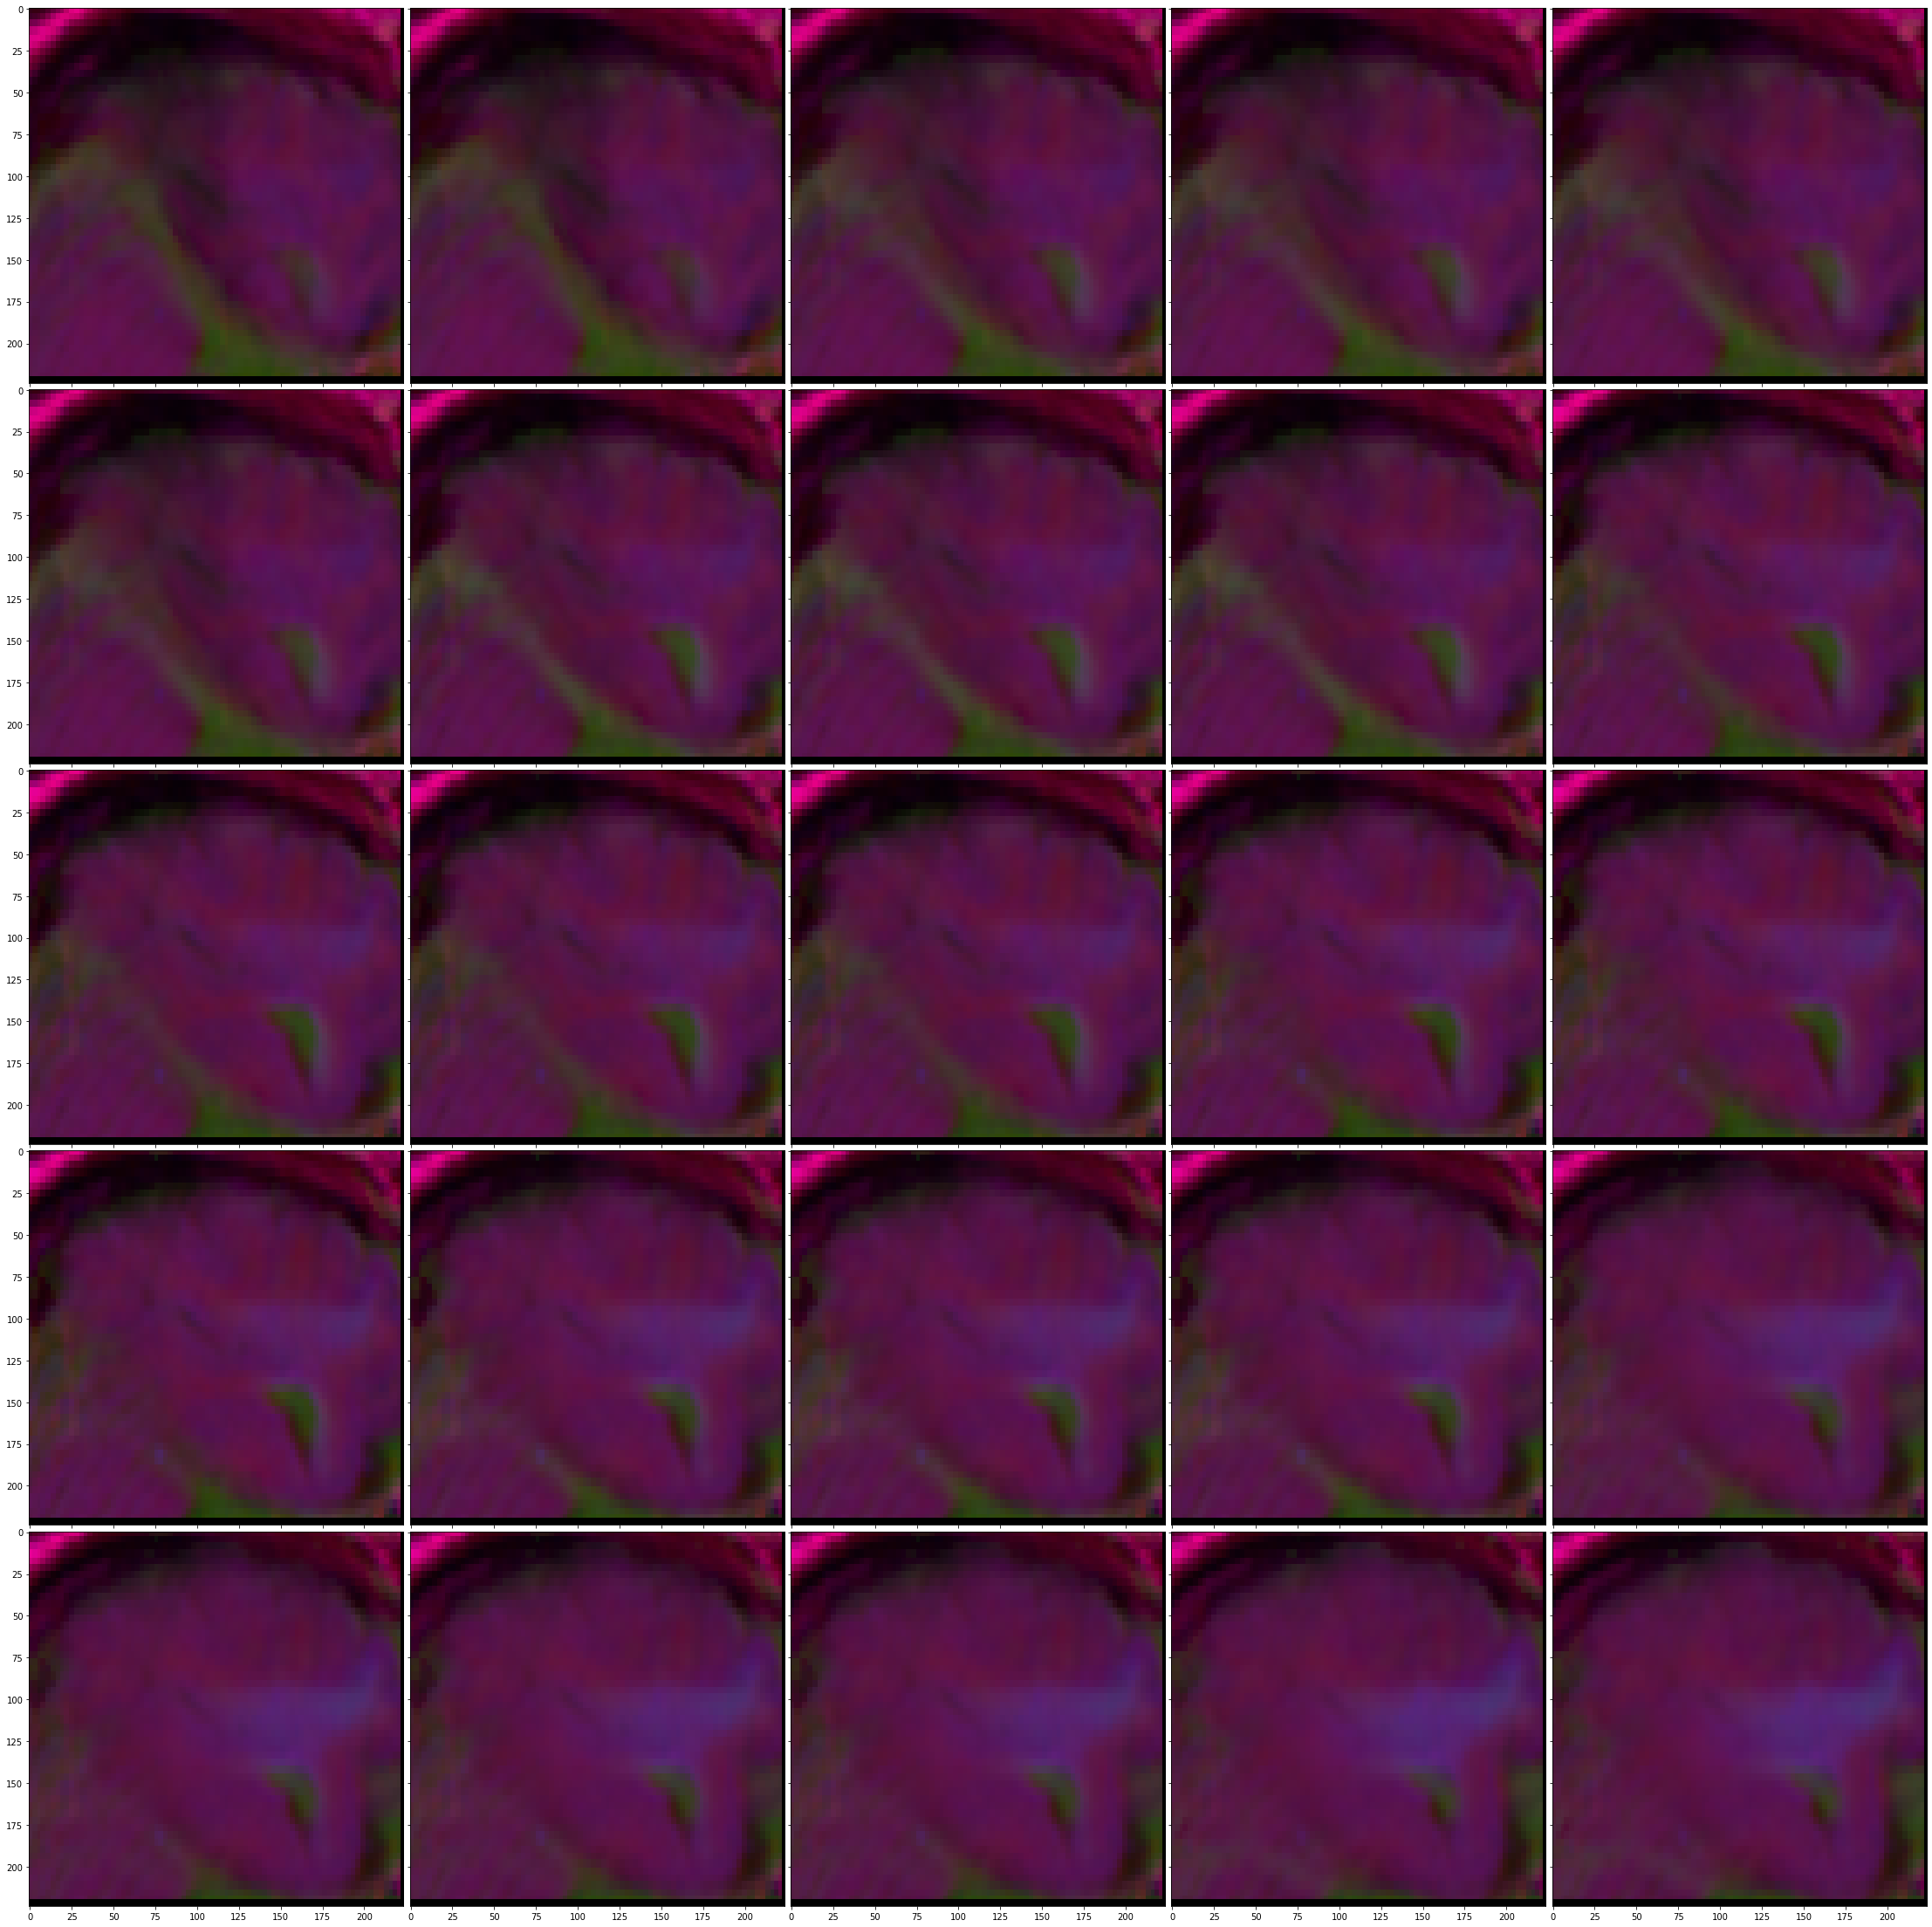

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
from nilearn.image import resample_to_img

fig = plt.figure(figsize=(40., 40.))

grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, img in zip(grid, unwrap_x[:25]):
    # Iterating over the grid returns the Axes.
    ax.imshow(img)

plt.show()

In [ ]:
from skimage import transform,io

# read in grey-scale
grey = io.imread('your_image.png', as_grey=True)
# resize to 28x28
small_grey = transform.resize(grey, (28,28), mode='symmetric', preserve_range=True)
# reshape to (1,784)
reshape_img = small_grey.reshape(1, 784)